In [1]:
from mss import mss
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from tensorflow.keras.utils import to_categorical
from PIL import Image
#import pyautogui
import keyboard
import mouse
import pytesseract
from time import sleep
import winsound
from re import sub

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [3]:
class Dataset(torch.utils.data.Dataset):
    '''
    Generates commands for Hakisa. Based on NLP/Classic RL approach.

        Commands = list of all possible commands(command type + action1 + action2).
    '''
    
    def __init__(
        self,
        commands=None,
        top=0,
        left=0,
        width=1920,
        height=1080,
        resize=None
    ):

        # Window resolutions for the screen grabber
        self.top = top
        self.left = left
        self.width = width
        self.height = height

        self.resize = resize # For reducing the images. Must be a tuple (Height, Width)

        self.commands = commands


    # Pytorch's Dataset functions will only be used in Studying mode
    def __getitem__(self, idx):

        inputs = self.data[idx]
        return inputs


    def __len__(self):

        return len(self.data)


    def _grab_frame(self):
        # Unfortunately, this whole operation takes about 0.6 seconds, so we'll probably have to deal with a single frame each 1~3 seconds.
        with mss() as sct:
            frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
            frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if self.resize:
                frame = frame.resize(self.resize)

            frame = np.array(frame, dtype=np.float32)

            frame = torch.from_numpy(frame)
        
        frame = frame.view(1, frame.size(2), frame.size(0), frame.size(1)).to(device) # (Batch, Channels, Height, Width)

        return frame


    def get_command(self, idx):
        '''
        Model output = LogSoftmax Output
        '''
        command = self.commands[idx]

        return command

    def get_consequences(self, top, left, width, height, togray=False, threshold=False, thresh_gauss=171, thresh_C=13, tesseract_config='--psm 8'):
        '''
        Used after Hakisa performed an input, in order to get its consequences(ex: score change, bombs, kills, deaths...).
        Returns a string according to Tesseract's OCR.
        '''

        with mss() as sct:
            consequence = sct.grab(monitor={"top": top, "left": left, "width": width, "height": height})

            consequence = Image.frombytes("RGB", consequence.size, consequence.bgra, 'raw', 'BGRX')

        if togray is True:

            consequence = consequence.convert("P") # Sometimes, simply converting to grayscale is enough

            if threshold is True:
                if "ADAPTIVE_THRESH_GAUSSIAN_C" and "adaptiveThreshold" and "THRESH_BINARY" not in dir():
                    from cv2 import adaptiveThreshold, ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY

                consequence = adaptiveThreshold(np.array(consequence),255,ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY,thresh_gauss,thresh_C)
                consequence = Image.fromarray(consequence)
        
        consequence = pytesseract.image_to_string(consequence, config=tesseract_config) 

        # OCR adds some strange characters(even with the whitelist function). Let's remove them.

        consequence = sub('[^A-Za-z0-9/.]', '', consequence) # Attention: 0, 1 and 8 can be seen as O, l and B.

        return consequence

    def record_gameplay(self, number_of_screenshots, screenshot_delay, grayscale=False, resize=False, path=None):

        # Resizing and grayscaling isn't really necessary here, but can save you some time later.
        # Both saving you from writing more code and from making your hardware having to process more and more data at once.

        print(f"Ok. Screenshot capture will begin in 5 seconds")

        sleep(5)

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME) # Just to know if everything's ok

        for i in range(number_of_screenshots):

            with mss() as sct:

                frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
                frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if grayscale:

                frame = frame.convert('L')

            if resize:

                frame = frame.resize(self.resize)

            frame.save(f"{path}/{i+2000}.png")

            sleep(screenshot_delay)
        
        print("Screenshot capture finished!")

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME)

In [4]:
commands = [
    'down_up', 'down_down', 'down_left', 'down_right', 'down_z', 'down_shift',
    'up_up', 'up_down', 'up_left', 'up_right', 'up_z', 'up_shift', 'press_x'
]

dataset = Dataset(commands, resize=(200, 200))

In [5]:
print(dataset.commands)

['down_up', 'down_down', 'down_left', 'down_right', 'down_z', 'down_shift', 'up_up', 'up_down', 'up_left', 'up_right', 'up_z', 'up_shift', 'press_x']


In [5]:
def preprocess_Jigoku(score):
    # For the game Jigoku Kisetsukan: Sense of the Seasons

    score = score.replace('S', '5').replace('s', '8').replace('e', '2').replace('O', '0').replace('B', '8').replace('o', '4').replace('b', '4')
    score = score.replace('I', '1').replace('l', '1').replace('.', '')

    try:
        score = float(score)

    except ValueError:
            score = 1.0

    return score

# Traditional Approach for Reinforcement Learning using Policy-based method ---> Actor-Critic.

There's 2 traditional approaches for RL: Off-Policy and On-Policy. Off-Policy is normally about Q-Learning algorithms, such as RainbowDQN.
Those, however, are too costly, as those requires memory so it can map states --> values(reward) and make a backpropagation...or even not use neural networks at all.

On-Policy are more used in uncertain environments and is based on Temporal-Difference Learning, not relying on memory.
On-Policy algorithms can be 2 algorithms: the policy algorithm, which tries to map a given state to possible actions; and the agent algorithm, which executes
an action and predicts an expected reward.

The Policy algorithm can be a Neural Network. In this case, it's quite similar to NLP, receiving an input and trying to extract a context(or actions) related
to that input. We could think of if as a Vectorizer, making the work analogue to an Embedding Matrix:

    Sequence of words(integers) -----------> Embedding Layer ------------> Context(Words vectors, floats)

    Game frame(RGB or grayscale image, float) ------> Vectorizer --------> Context(Actions vectors, floats)

    Such comparison is more explicit in Liu Ruo-Ze et al.'s HierNet, where Embedding, Transformers and LSTMs have been used.

The Agent algorithm can also be a Neural Network, executing a simple, more mundane Regression task and trying to predict the reward to be obtained.


Instead of using 2 neural networks, however, we'll be using a single one, combining the policy and the agent ---> Actor-Critic.
This method is more similar to the human brain(and cerebellum?), where the Broadmann's Areas 17, 18, 19 receives the game frames, extracts features and
send them to the Area 9, where the possible actions are calculated, with the expected consequence for each action, and the true action is decided by Areas 11, 12.
If our action generates the consequence we were expecting(usually a good one), the limbic system awards us with a reward.
The higher the difference between the expected consequence and the actual consequence, the lower our reward, which can be negative(sadness, angriness):

    Actor Critic: Receives current state ----> Predicts both probability of actions and predicts expected cumulative reward

This is the method used by OpenAI's PPO. However, PPO uses Assynchronous Advantage Actor-Critic(A3C), running multiple agents in parallel
in order to make the process faster.

Can be used in simple games to check if our strategy is running as planned.

There's no Exploration nor Study Mode. Everything goes in real-time.

How it works:

Model receives current state(game frame) ------> Feature Extraction

Features -------> Vectorizer -------> Possible Actions

Possible Actions -------> "Dead" layer(no optimization) ----> True Action(action to be executed)

Features + True Action -------> Predicted Reward (Calculating Predicted reward only for the true action)

    The action to be executed is sampled from the actions probability, which provides certain variety of actions(we won't be always dealing with the same action),
    and the actions loss function is given by Cross-Entropy Loss(Possible Actions, True Action), where True Action is the action that was executed.

    The predicted reward is compared with the actual cumulative reward ---> MSE or MAE(HuberLoss) ---> Backpropagation
    
    *An alternative to the MSE(predicted_reward, cumulative_reward) is actually using the advantage, which is given by:
        advantage = predicted_reward - previous_reward

    However, if the previous assumptions about the human decision process are correct and we were to mymetize this in a RL algorithm,
    our True Action would be a weighted sample from the possible actions where the weights are the expected rewards for each action.
    The result would be:

    Features + Possible Actions -------> Expected Reward for each Action

    (Possible Actions * Expected Reward per action) ---------> True Action(action to be executed)

    The expected reward per action could compensate the softmax tendency of always providing the same action as "best action".

    But then, let's start with the classic first.

**PS: This approach is actually used to calculate the advantage for the surrogate loss in PPO.**


This process combines TD-Learning and a Policy and it's OpenAI's default technique, being used in ChatGPT
(and probably in Tesla cars, since the CEO's the same).
It's also more similar to NLP, where the Vectorizer makes the work analogue to an Embedding Matrix:

    Sequence of words(integers) -----------> Embedding Layer ------------> Context(Words vectors, floats)

    Game frame(RGB or grayscale image, float) ------> Vectorizer --------> Context(Actions vectors, floats)

    Such comparison is more explicit in Liu Ruo-Ze et al.'s HierNet, where Embedding, Transformers and LSTMs have been used.

According to ChatGPT:
"In policy-based reinforcement learning,
the goal is to learn a policy that directly maps states to actions,
rather than learning a value function that predicts the expected return for each action.
The agent's policy is typically represented by a probability distribution over the action space,
which specifies the probability of selecting each possible action given a particular state."

In [42]:
class RLNutshell(torch.nn.Module):

    '''
    Traditional Approach for Reinforcement Learning using Policy-based method ---> Actor-Critic.
    
    Can be used in simple games to check if our strategy is running as planned.

    There's no Exploration nor Study Mode. Everything goes in real-time.

    This model includes Softmax Activation Function, which limits the viability of this approach to simple keyboard games in order to avoid bottlenecks

    This approach might not be viable to mouse games(since the screen coordinates leads to matrices with dimensions that are too great),
    but sometimes we have to take a step back in order to leap forward.

    In Gym and using PPO, there are multiple environments running at once.
    We can't do this here, but we could generate multiple outputs and concatenate then in a tuple (possible_actions, predicted_reward)
    and select the one with lower loss. This, however, is more expensive and we won't try this for now.
    '''

    def __init__(self, commands, epsilon):

        super(RLNutshell, self).__init__()

        self.commands = len(commands)
        self.epsilon = epsilon # Used to determine whether to explore or simply select the best action.
        # This method is more used in Q-Learning, but can be used in Actor-Critic as well.

        # Sticking to the traditional approach first. We might use Attention Layers if those are indeed effective.

        self.conv1 = torch.nn.Conv2d(3, 100, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(100)
        self.conv2 = torch.nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1, bias=False) # 200x200
        self.batchnorm2 = torch.nn.BatchNorm2d(100)
        # Add pool 2x2 ---> 100x100
        self.conv3 = torch.nn.Conv2d(100, 200, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm3 = torch.nn.BatchNorm2d(200)
        self.conv4 = torch.nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm4 = torch.nn.BatchNorm2d(200)
        # Add pool 2x2 ---> 50x50
        self.conv5 = torch.nn.Conv2d(200, 400, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm5 = torch.nn.BatchNorm2d(400)
        self.conv6 = torch.nn.Conv2d(400, 400, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm6 = torch.nn.BatchNorm2d(400)
        # Add pool 2x2 ---> 25x25
        self.conv7 = torch.nn.Conv2d(400, 800, kernel_size=4, stride=1, bias=False) # 22x22
        self.batchnorm7 = torch.nn.BatchNorm2d(800)
        self.conv8 = torch.nn.Conv2d(800, 800, kernel_size=3, stride=1, bias=False) # 20x20
        self.batchnorm8 = torch.nn.BatchNorm2d(800)
        # Add pool 2x2 ---> 10x10
        self.conv9 = torch.nn.Conv2d(800, 1000, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm9 = torch.nn.BatchNorm2d(1000)
        self.conv10 = torch.nn.Conv2d(1000, 1000, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm10 = torch.nn.BatchNorm2d(1000)
        # Add pool 2x2 ---> 5x5

        self.neuron_in = torch.nn.Linear(1000*5*5, 100, bias=False)

        self.neuron_vectorizer = torch.nn.Linear(100, len(commands), bias=False)

        #self.select_action = torch.nn.Linear(len(commands), 1, bias=False) # To test with weighted sampling. Outputs must be [0, len(commands)], so beware.

        self.pred_reward = torch.nn.Linear(100+1, 1, bias=False)

        self.pool2x2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.LRelu = torch.nn.LeakyReLU(0.25)
        #self.softmax = torch.nn.LogSoftmax(-1)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, input_frame, previous_cumulative_reward):

        x = self.conv1(input_frame)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv3(x)
        x = self.batchnorm4(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv7(x)
        x = self.batchnorm7(x)
        x = self.conv8(x)
        x = self.batchnorm8(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = self.conv9(x)
        x = self.batchnorm9(x)
        x = self.conv10(x)
        x = self.batchnorm10(x)
        x = self.LRelu(x)

        x = self.pool2x2(x)

        x = x.view(x.size(0), -1)

        x = self.neuron_in(x) # (Batch, 100). Since we're capturing a single frame at time, our Batch = 1.
        # If we were running more game instances in parallel, our Batch would be equal to the number of game instances.

        possible_actions = self.neuron_vectorizer(x) # (Batch, len(commands))
        possible_actions = self.softmax(possible_actions) # The probability distribution of possible actions, the output of an Optimal Stochastic Policy Neural Network.

        # Calculating possible reward for each action

        expected_reward = torch.zeros_like(possible_actions, device=device)

        for action in range(self.commands):

            y = torch.cat((x, possible_actions[0, action].unsqueeze(0).unsqueeze(0)), -1)
            y = self.pred_reward(y)
            expected_reward[0, action] = y.squeeze(0)

        del y

        #expected_reward = torch.mean(expected_reward)

        if torch.rand((1,)) < self.epsilon: # The higher the epsilon, the more random our model will be. The lower, the more deterministic.
            # The expected reward can also be used for sampling, but let's stick to epsilon for now.

            true_action = torch.randint(0, self.commands, (1, 1), device=device)
        
        else: # We can't use .argmax() directly as this detaches the tensor's graphs, since argmax isn't differentiable.

            one_hot = torch.zeros_like(possible_actions, device=device)
            one_hot[0, possible_actions.argmax()] = 1.
            true_action = possible_actions * one_hot
            true_action = torch.sum(true_action, dim=-1, keepdim=True)

        one_hot = torch.zeros_like(possible_actions, device=device)
        one_hot[0, possible_actions.argmax()] = 1.
        predicted_reward = expected_reward * one_hot
        predicted_reward = torch.sum(predicted_reward, dim=-1, keepdim=True)

        expected_reward = torch.mean(expected_reward)

        return possible_actions, true_action, predicted_reward, expected_reward

    def execute_command(self, command):
        '''
        Command must be an item from the commands list. Make sure all commands are lowered words.
        For now, we'll also suppose that all commands are keyboard commands.
        '''

        command = command.split("_")

        if "down" in command:

            keyboard.press(command[1])

        elif "up" in command:

            keyboard.release(command[1])

        else: # Press and Release

            keyboard.send(command[1])

In [15]:
model = RLNutshell(commands, epsilon=0.2).to(device)

In [70]:
reward = torch.zeros((1, 1), device=device) # Cumulative reward
reward_input = reward.clone()
previous_value = torch.zeros((1, 1), device=device) # Initial value function Weighted Moving Average
steps = 0
save_point = 10 # Also optimization point
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
grads = []

reward_loss = torch.nn.HuberLoss(delta=100)
actions_loss = torch.nn.CrossEntropyLoss()

sleep(5)

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)


while keyboard.is_pressed('esc') == False: # Exit loop when Esc is pressed

    frame = dataset._grab_frame()

    possible_actions, true_action, predicted_reward, _ = model(frame, reward_input)

    del frame

    command = dataset.get_command(true_action.detach().cpu().item())

    model.execute_command(command)

    life = dataset.get_consequences(849, 400, 498-400, 904-849, tesseract_config='--psm 8')

    life = preprocess_Jigoku(life)

    if life <= 1:

        reward -= 1.

    else:

        reward += 1.

    del life

    reward = torch.tensor(reward, device=device)

    # PPO updates the policy based on the previous policy parameters, which can also be seen as the previous policy outputs
    # Traditionally, however, we use the possible actions(policy output) and the true action(agent output)

    command_loss = actions_loss(possible_actions, true_action.detach().squeeze(0))
    value_loss = reward_loss(predicted_reward, reward)

    total_loss = command_loss + value_loss

    total_loss.backward()

    try:

        grads.append(torch.mean(model.neuron_vectorizer.weight.grad))

    except:

        pass

    steps += 1

    reward_input = reward.clone()
    

    if steps % save_point == 0:

        optimizer.step()
        #scheduler.step()

        model.zero_grad()

        print(f"Current step: {steps}")
        #print(f"Current Loss: {total_loss.item()}\tCurrent LR: {scheduler.get_last_lr()[0]}")
        print(f"Current Loss: {total_loss.item()}")
        print(f"Action Loss: {command_loss.item()}\tReward Loss: {value_loss.item()}")
        print(f"Predicted Reward: {predicted_reward.item()}\tCurrent Reward: {reward.item()}")
        print(command)

        '''torch.save({
            'Steps': steps,
            'Hakisa_params': best_params,
            'Hakisa_LR': scheduler.get_last_lr()[0]
        }, f"{save_path}/Hakisa_checkpoint.tar")'''


        winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

C:\Users\giova\AppData\Local\Temp/ipykernel_19280/3443294517.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, device=device)


Current step: 10
Current Loss: 52.12706756591797
Action Loss: 2.549668788909912	Reward Loss: 49.57740020751953
Predicted Reward: 0.047055453062057495	Current Reward: 10.0
up_left
Current step: 20
Current Loss: 7.34737491607666
Action Loss: 2.5853519439697266	Reward Loss: 4.762022972106934
Predicted Reward: 18.793216705322266	Current Reward: 20.0
down_down
Current step: 30
Current Loss: 108.53346252441406
Action Loss: 2.663149356842041	Reward Loss: 105.87031555175781
Predicted Reward: 14.942988395690918	Current Reward: 28.0
down_left
Current step: 40
Current Loss: 48.827980041503906
Action Loss: 1.770707130432129	Reward Loss: 47.057273864746094
Predicted Reward: 31.443038940429688	Current Reward: 38.0
up_up
Current step: 50
Current Loss: 56.66971206665039
Action Loss: 2.6858973503112793	Reward Loss: 53.98381423950195
Predicted Reward: 41.78805923461914	Current Reward: 48.0
up_down
Current step: 60
Current Loss: 45.13782501220703
Action Loss: 1.6972062587738037	Reward Loss: 43.4406204223

### For PPO:

https://github.com/liuruoze/HierNet-SC2/blob/main/algo/ppo.py

https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

expected_reward = torch.mean(reward_for_each_action)

advantage = predicted_reward - expected_reward

surrogate_loss = (possible_actions.argmax()/previous_possible_actions.argmax()) * advantage # Add clip (ratio can't be greater than 0.2)


predicted_value = predicted_reward + discount_factor*previous_reward

current_value = reward + discount_factor*previous_reward

value_loss = mse(predicted_value, current_value) ---------> value_loss = mse(predicted_reward, reward)


total_loss = surrogate_loss + value_loss*0.5

In [51]:
model = RLNutshell(commands, epsilon=0.2).to(device)

In [52]:
# Initializing the model weights: https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/ - Item 2
import math

torch.nn.init.orthogonal_(model.neuron_in.weight, math.sqrt(2))
torch.nn.init.orthogonal_(model.neuron_vectorizer.weight, 0.01)
torch.nn.init.orthogonal_(model.pred_reward.weight, 1)

Parameter containing:
tensor([[-5.1686e-02,  8.5438e-02, -3.6007e-02,  1.8787e-02,  4.3484e-02,
          1.0793e-01, -1.2112e-01,  1.2513e-02, -1.8009e-01, -7.2568e-02,
          1.8884e-01, -3.5154e-02,  6.1086e-03,  1.9923e-02,  1.9526e-02,
          6.6890e-02,  1.0109e-01,  1.4790e-01, -4.5165e-03, -1.3757e-01,
         -3.3153e-02, -2.5010e-03,  1.2422e-01, -1.8540e-02, -1.4943e-02,
          1.5786e-01, -3.9742e-01, -1.2863e-01, -6.4086e-02,  1.3487e-02,
          1.7874e-01,  5.5828e-02,  5.1097e-02, -4.2842e-02, -5.7433e-02,
         -7.9712e-02, -9.6630e-02,  4.9805e-02, -7.0034e-02, -7.9895e-02,
          2.8797e-02, -1.1362e-01,  1.1717e-01, -3.6348e-02, -7.2291e-02,
          6.6278e-02, -3.9130e-02, -1.1846e-01,  5.9452e-02,  1.1040e-02,
         -6.3735e-02,  5.5863e-03, -1.9960e-01,  3.8771e-02,  5.5197e-02,
         -6.5724e-02, -1.6580e-01,  3.9302e-02,  6.0213e-02,  2.5666e-02,
          1.9644e-02,  9.5550e-02,  1.2468e-01,  5.4121e-02,  5.0882e-02,
         -2.8105

In [53]:
reward = torch.zeros((1, 1), device=device) # Cumulative reward
steps = 0
save_point = 10 # Also optimization point
#uncertainty_factor = 0.9 # Also known as gamma or discount factor
action_grads = []
reward_grads = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-8) # 1e-4 is a common LR. But 1e-6 is also used by RainbowDQN and it's the best one for HierNet
# Note: PPO also uses epsilon = 1e-5, but it seems that eps=1e-7 or 1e-8 are better.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, gamma=0.1) # The learning rate should decay linearly until it vanishes

reward_loss = torch.nn.HuberLoss(delta=100)
actions_loss = torch.nn.CrossEntropyLoss()

sleep(5)

winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)


#while keyboard.is_pressed('esc') == False: # Exit loop when Esc is pressed
while steps < 1000:

    frame = dataset._grab_frame()

    reward_input = reward.clone() # To avoid issues with inplace operations

    possible_actions, true_action, predicted_reward, expected_reward = model(frame, reward_input)

    del frame

    command = dataset.get_command(int(true_action.detach().cpu().item()))

    model.execute_command(command)

    life = dataset.get_consequences(849, 400, 498-400, 904-849, tesseract_config='--psm 8')

    life = preprocess_Jigoku(life)

    if life <= 1:

        reward -= 1.

    else:

        reward += 1.

    del life

    reward = torch.tensor(reward, device=device)

    advantage = predicted_reward - expected_reward
    
    try:
        one_hot = torch.zeros_like(possible_actions, device=device)
        one_hot[0, possible_actions.argmax()] = 1.
        possible_actions = possible_actions * one_hot
        possible_actions = torch.sum(possible_actions, dim=-1)
        
        ratio = possible_actions/previous_possible_actions

        ratio = torch.clamp(ratio, min=0.2, max=0.2)

        surrogate_loss = ratio * advantage

        value_loss = reward_loss(predicted_reward, reward) # Consider computing the advantage and the imediate reward

        total_loss = surrogate_loss + (value_loss * 0.5)

        total_loss.backward()

    except:
        pass

    try:
        action_grads.append(torch.mean(model.neuron_vectorizer.weight.grad))
        reward_grads.append(torch.mean(model.pred_reward.weight.grad))
    
    except:
        pass

    previous_possible_actions = possible_actions.detach()

    steps += 1
    

    if steps % save_point == 0:

        optimizer.step()
        #scheduler.step()

        model.zero_grad()

        print(f"Current step: {steps}")
        print(f"Current Loss: {total_loss.item()}")
        print(f"Action Loss: {surrogate_loss.item()}\tAdvantage: {advantage.item()}\tRatio: {ratio.item()}\tReward Loss: {value_loss.item()}")
        print(f"Predicted Reward: {predicted_reward.item()}\tCurrent Reward: {reward.item()}")
        print(command)

        '''torch.save({
            'Steps': steps,
            'Hakisa_params': best_params,
            'Hakisa_LR': scheduler.get_last_lr()[0]
        }, f"{save_path}/Hakisa_checkpoint.tar")'''


        winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)

C:\Users\giova\AppData\Local\Temp/ipykernel_11776/3356857927.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, device=device)


Current step: 10
Current Loss: 23.693843841552734
Action Loss: -2.568960189819336e-05	Advantage: -0.0001284480094909668	Ratio: 0.20000000298023224	Reward Loss: 47.38773727416992
Predicted Reward: 0.2647300362586975	Current Reward: 10.0
down_up
Current step: 20
Current Loss: 324.6003112792969
Action Loss: -0.0002471923944540322	Advantage: -0.0012359619140625	Ratio: 0.20000000298023224	Reward Loss: 649.2011108398438
Predicted Reward: 56.033348083496094	Current Reward: 20.0
down_down
Current step: 30
Current Loss: 133.67982482910156
Action Loss: -7.190704491222277e-05	Advantage: -0.00035953521728515625	Ratio: 0.20000000298023224	Reward Loss: 267.35980224609375
Predicted Reward: 4.875994682312012	Current Reward: 28.0
down_up
Current step: 40
Current Loss: 300.2787780761719
Action Loss: -8.325577073264867e-05	Advantage: -0.0004162788391113281	Ratio: 0.20000000298023224	Reward Loss: 600.5577392578125
Predicted Reward: 3.3428871631622314	Current Reward: 38.0
down_up
Current step: 50
Current L

In [ ]:
print(torch.sum(model.pred_reward.weight))

In [55]:
print(total_loss)

tensor([[113.2831]], device='cuda:0', grad_fn=<AddBackward0>)


In [56]:
print(previous_possible_actions)
print(possible_actions)

tensor([0.9995], device='cuda:0')
tensor([0.9995], device='cuda:0', grad_fn=<SumBackward1>)


In [57]:
print(ratio)
print(advantage)
print(surrogate_loss)

tensor([0.2000], device='cuda:0', grad_fn=<ClampBackward1>)
tensor([[-0.1276]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[-0.0255]], device='cuda:0', grad_fn=<MulBackward0>)


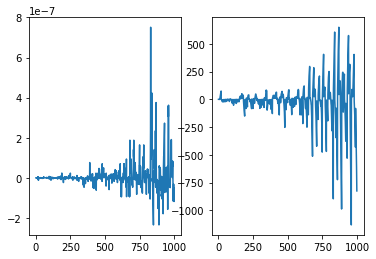

In [59]:
_, ax = plt.subplots(1, 2)

ax[0].plot(action_grads)
ax[1].plot(reward_grads)
plt.show()